In [2]:
# Dependencies and configuration
import os
from src.config import settings

os.makedirs(settings.panels_dir, exist_ok=True)
os.makedirs(settings.crops_dir, exist_ok=True)

In [ ]:
from modules.coreMPE.src.adenzu_panel.image_processing import panel

_ = panel.extract_panels_for_images_in_folder_recursive(
    input_dir=str(settings.pages_dir),
    output_dir=str(settings.panels_dir),
    split_joint_panels=False,   # maps to --split-joint-panels
    fallback=True              # maps to --fallback
)

In [ ]:
# Extract head crops (YOLOv8_animeface)
from src.headExtraction import anime_extraction_recursive

valid_exts = {".jpg", ".jpeg", ".png"}
panel_paths = sorted(
    [p for p in settings.panels_dir.iterdir() if p.suffix.lower() in valid_exts]
)
num_crops = anime_extraction_recursive()

print(f"Extracted {num_crops} faces")

In [6]:
# Calculate embeds of dataset
from src.recognitionModel import build_model, char_nearest_neighbor
IMG_SIZE = 192

embed_model = build_model(IMG_SIZE, settings.crops_dir)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Found 20654 crops under data/crops
Found 20654 crops under data/crops


Loading crops: 100%|██████████| 20654/20654 [01:00<00:00, 339.00it/s]



Successfully loaded 20654 crops
323/323 ━━━━━━━━━━━━━━━━━━━━ 211s 644ms/step
323/323 ━━━━━━━━━━━━━━━━━━━━ 211s 644ms/step
Generated embeddings of shape (20654, 1024)
Saved embeddings to data/embeddings.npy
Saved crop paths to data/crop_paths.json
Generated embeddings of shape (20654, 1024)
Saved embeddings to data/embeddings.npy
Saved crop paths to data/crop_paths.json


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step
Found 1977 crops above similarity threshold 0.8
Showing top 40 results out of 1977 matches
Found 1977 crops above similarity threshold 0.8
Showing top 40 results out of 1977 matches


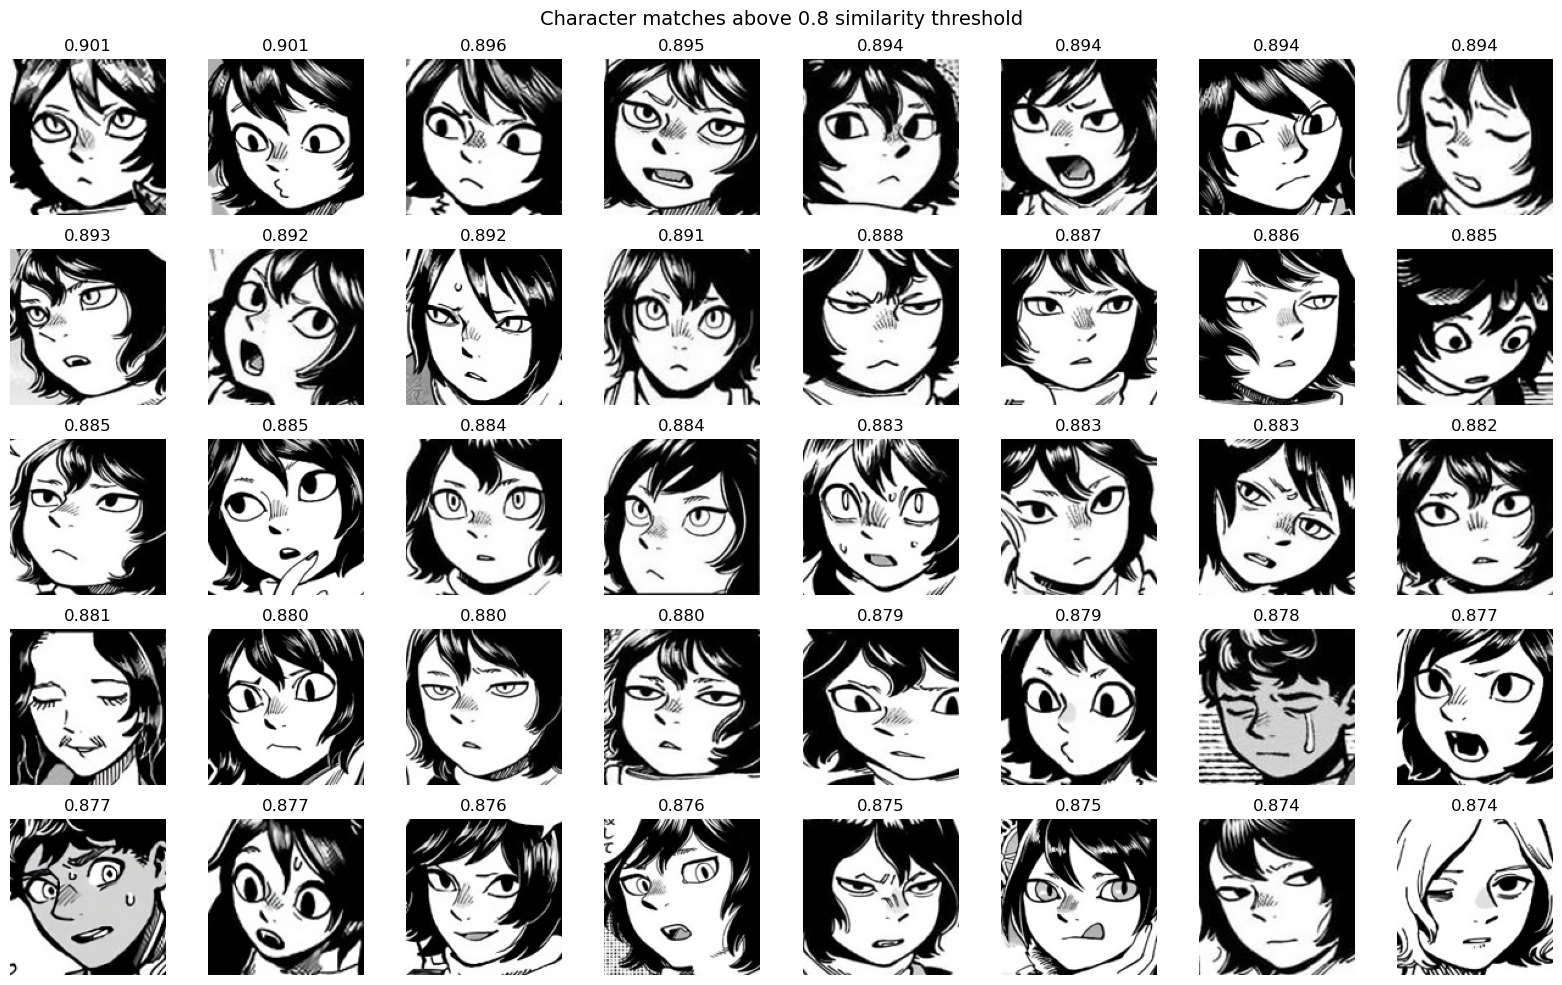

In [7]:
# Set similarity threshold (0-1, higher = more strict)
# 0.7 = fairly similar, 0.8 = very similar, 0.6 = somewhat similar
similarity_threshold = 0.8
seed_paths = [str(p) for p in sorted(settings.izutsumi_dir.glob("*.jpg"))] # Seeds

# Find character matches above threshold
results = char_nearest_neighbor(
    settings.embed_path, 
    settings.crop_path, 
    IMG_SIZE, 
    embed_model, 
    seed_paths,
    similarity_threshold=similarity_threshold
)